In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import mysql.connector
import requests
from mysql.connector.connection import MySQLConnection
from typing import Dict,List,Tuple,Any,Optional
import py7zr  # For handling .7z files
from tqdm import tqdm # progress bar for download
import math
import matplotlib.pyplot as plt
import shutil

# Connection Variables
USER = 'Sudo'
PASSWORD = 'password'
DATABASE = 'sys' # Do not change! This is the default database for MySQL


#Server Connection Configuration
CONN_CONFIG: Dict[str, str]  = {
    "host": "localhost",
    "user": USER,
    "password": PASSWORD,
    "database": DATABASE
}

DBSTART = 'Contoso' # Name of the database to create and where all other tables will be created

CONTOSO_DOWNLOAD_LINK = r"https://github.com/sql-bi/Contoso-Data-Generator-V2-Data/releases/download/ready-to-use-data/csv-10m.7z"
CONTOSO_FILENAME = "csv-10m.7z"# DO NOT CHANGE THIS VALUE!
EXTRACT_DIR = f"{os.path.expanduser('~')}\\Downloads\\{DBSTART}\\"


def download_file(url: str, filename: str) -> None:
    """
    Downloads a file from a given URL and saves it to the user's Downloads folder,
    with a progress bar displayed in the console.

    :param url: The URL of the file to download.
    :param filename: The name of the file to save.
    :return: None
    """
    user_downloads_dir = os.path.join(os.path.expanduser("~"), "Downloads")
    file_path = os.path.join(user_downloads_dir, filename)

    with requests.get(url, stream=True) as response:
        response.raise_for_status()  # Raise an error for bad responses (4xx or 5xx)

        # Get the total file size from the headers
        total_size = int(response.headers.get('content-length', 0))

        with open(file_path, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as progress_bar:
                for chunk in response.iter_content(chunk_size=1024):  # Download in 1KB chunks
                    f.write(chunk)
                    progress_bar.update(len(chunk))  # Update the progress bar

    print(f"File downloaded to: {file_path}")


def extract_archive(filename: str) -> Optional[str]:
    """
    Searches for a given .7z archive file in the user's Downloads folder,
    and extracts its contents to DOWNLOADS_DIR with a progress bar and detailed error handling.

    :param filename: The name of the .7z archive file to extract.
    :return: The path where files were extracted or None if extraction failed.
    """
    user_downloads_dir = os.path.join(os.path.expanduser("~"), "Downloads")
    file_path = os.path.join(user_downloads_dir, filename)

    # Check if the file exists in Downloads folder
    if not os.path.exists(file_path):
        print(f"Error: File '{filename}' not found in {user_downloads_dir}.")
        return None

    # Ensure the extraction directory exists
    os.makedirs(EXTRACT_DIR, exist_ok=True)

    try:    
        if filename.endswith(".7z"):
            # Extract .7z files with a progress bar
            try:
                counter = 0 
                with py7zr.SevenZipFile(file_path, mode='r', blocksize=1024*1024 ) as archive:
                    file_list = archive.getnames()
                    
                    with tqdm(total=len(file_list), unit="Files Extracted", desc="Extracting") as  files_progress_bar:
                
                        for file in file_list:
                            try:
                                files_progress_bar.set_description(f"Extracting {file}...")
                                files_progress_bar.refresh()
                                archive.extract(targets=[os.path.join(user_downloads_dir,CONTOSO_FILENAME),file], path=EXTRACT_DIR, recursive=False)
                                archive.reset() 
                                files_progress_bar.update(1)
                                
                            except Exception as file_error:
                                print(f"Error extracting file '{file}': {file_error}")
                                continue
                            
                            counter += 1
                            if counter == len(file_list):
                                archive.close()
                                break
                
                print(f"Extracted '{filename}' to '{EXTRACT_DIR}'.")
                return EXTRACT_DIR
           
            except py7zr.Bad7zFile:
                print(f"Error: '{filename}' is not a valid 7z file.")
                return None
           
            except Exception as e:
                print(f"Error extracting 7z file '{filename}': {e}")
                return None

        else:
            print(f"Error: '{filename}' is not a supported archive format (7z).")
            return None

    except PermissionError:
        print(f"Error: Permission denied while accessing '{filename}' or writing to '{EXTRACT_DIR}'.")
        return None
    
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found during extraction.")
        return None
    
    except Exception as e:
        print(f"Unexpected error while extracting '{filename}': {e}")
        return None


def create_database(db_name: str = None) -> None:
    """
    Creates a new MySQL database if it does not exist.

    :param db_name: Name of the database to create.
    :return: None
    """
    try:
        # Connect to MySQL Server (without specifying a database)
        conn: MySQLConnection = mysql.connector.connect(**CONN_CONFIG)
        cursor = conn.cursor()

        # Create database if it doesn't exist
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS `{db_name}`;")
        print(f"Database `{db_name}` created or already exists.")

        # Close connection
        cursor.close()
        conn.close()

    except mysql.connector.Error as err:
        print(f"Error: {err}")


def infer_mysql_dtype(series: pd.Series) -> str:
    """
    Infers the MySQL data type based on an analysis of a column's values from CSV data.
    """
    
    datetime_formats = {
        "DATETIME": [
            "%Y-%m-%d %H:%M:%S",
            "%d-%m-%Y %H:%M:%S",
            "%m/%d/%Y %H:%M:%S"
        ],
        "DATE": [
            "%Y-%m-%d",
            "%d-%m-%Y",
            "%m/%d/%Y",
            "%d %b %Y",
            "%d %B %Y"
        ],
    }

    non_null_values = series.dropna()
    # default if column is empty
    if non_null_values.empty:
        return "VARCHAR(255)"
      
    def check_datetime(value):
        for fmt in datetime_formats["DATETIME"]:
            try:
                pd.to_datetime(value, format=fmt)
                return "DATETIME"
          
            except ValueError:
                continue
     
        for fmt in datetime_formats["DATE"]:
            try:
                pd.to_datetime(value, format=fmt)
                return "DATE"
            except ValueError:
                continue
        return None

    inferred_types = {"int": 0, "float": 0, "datetime": 0, "date": 0, "str": 0, "bit":0}
    max_str_len = 0
    is_bit_candidate = None

    for x in non_null_values:
        val = x # force native python type
        
        if isinstance(val, bool):
            inferred_types["bit"] += 1
        
        elif isinstance(val, int) and val in (0, 1):
            inferred_types["bit"] += 1
        
        else:
            is_bit_candidate = False 
        
        
        if isinstance(val, int):
            inferred_types["int"] += 1
        
        elif isinstance(val, float):
            inferred_types["float"] += 1
        
        elif isinstance(val, str):
            max_str_len = max(max_str_len, len(val))
            dt_type = check_datetime(val)
        
            if dt_type == "DATETIME":
                inferred_types["datetime"] += 1
        
            elif dt_type == "DATE":
                inferred_types["date"] += 1
        
            else:
                inferred_types["str"] += 1

    # Determine dominant type
    
    if is_bit_candidate and inferred_types["bit"] == len(non_null_values):
        return "BIT"
    
    if inferred_types["int"] == len(non_null_values):
            return "INT"

    elif inferred_types["float"] + inferred_types["int"] == len(non_null_values):
        return "DECIMAL(18,6)"

    elif inferred_types["datetime"] > 0 and inferred_types["datetime"] + inferred_types["str"] == len(non_null_values):
        return "DATETIME"
    
    elif inferred_types["date"] > 0 and inferred_types["date"] + inferred_types["str"] == len(non_null_values):
        return "DATE"

    elif inferred_types["str"] > 0:
    
        if max_str_len <= 255:
            return f"VARCHAR(255)"
    
        elif max_str_len <= 65535:
            return "TEXT"
    
        else:
            return "LONGTEXT"

    return "VARCHAR(255)"


def count_rows_in_csv(filepath: str) -> int:
    """
    Counts the number of rows in a CSV file.

    :param filepath: Path to the CSV file.
    :return: Number of rows in the CSV file.
    """
    try:
        with open(filepath, 'r') as file:
            total_rows = sum(1 for _ in file) - 1  # Subtract 1 for the header row
        return total_rows
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return 0
 

def compute_scale(x: int, min_x: int = 0, max_x: int = 10000000, min_scale: float = 0.01, max_scale: float = 0.20) -> float:
    
    if not (min_x <= x <= max_x):
        raise ValueError("Input must be between 0 and 10,000,000")

    # Normalize using log scale to emphasize early values
    log_x = math.log10(x + 1)  # avoid log(0)
    log_max = math.log10(max_x + 1)
    scale = max_scale - (log_x / log_max) * (max_scale - min_scale)
    
    return round(scale, 6)


def create_tables_from_csv(targetdirectory: str = EXTRACT_DIR ) -> None:
    """
    Scans CSV files in a given directory, infers table schema, 
    and creates MySQL tables dynamically based on CSV headers and data types.
    then loads the data into the tables.

    :return: None
    """
    csv_files = glob.glob(os.path.join(targetdirectory, "*.csv"))
    file_list = [(os.path.basename(file), file) for file in csv_files]
    chunk_size = 1000  # Number of rows per chunk
    conn = mysql.connector.connect(**CONN_CONFIG)
    cursor = conn.cursor()

    print(f"Found {len(file_list)} CSV files in {targetdirectory}.")

    # #######################
    # # Table Creation Loop #
    # #######################
    for filename, filepath in file_list:

        print(f"Begin table creation for file: {filename}...")
        
        table_name = os.path.splitext(filename)[0]  # Remove .csv extension

        df = pd.read_csv(filepath,nrows=1)
        columns = df.columns.tolist()
        total_row_count = count_rows_in_csv(filepath)
        total_row_count = min(total_row_count, 10000000)  # Limit to compute scale max_x default.
        scaling_factor = compute_scale(x=total_row_count)
        inferred_types = []
        
        print(f"Scaling factor for {filename}: {scaling_factor}...")
        print(f"Total rows in {filepath}: {total_row_count}...")
        
        for col in columns:
            print(f"Inferring data types for column: {col} in {filename}...")
            column_types = [] 

            with pd.read_csv(filepath, usecols=[col], chunksize=1000) as data:
                
                for chunk in data:
                    chunk = chunk.sample(frac=scaling_factor)
                    column_types.extend([infer_mysql_dtype(chunk[col])])
            
            # prefer VARCHAR over INT
            if "VARCHAR(255)" in column_types:
                most_frequent_type = "VARCHAR(255)"

            else:
                most_frequent_type = max(set(column_types), key=column_types.count)
            
            inferred_types.append(most_frequent_type)
            print(f"Data type inffered for '{col}': {most_frequent_type} \n \n ")
            
        
        columns_sql = ", ".join(f"{col} {dtype}" for col, dtype in zip(columns, inferred_types))
        create_table_sql = f" CREATE TABLE IF NOT EXISTS {DBSTART}.{table_name} ({columns_sql});"
        
        print(f"Executing {create_table_sql}...")
        cursor.execute(create_table_sql)
        
        #Confirm the table was created in the SQL server
        cursor.execute(
            f"""
            SELECT EXISTS(
                SELECT * FROM information_schema.tables 
                WHERE
                    table_type = 'BASE TABLE'
                    AND table_name = '{table_name}');
            """
        )
        table_check = cursor.fetchall()        
        
        try:
            if len(table_check) == 1 & table_check[0][0] == table_name:
                print(f"Table `{table_name}` created successfully. \n \n ")
        except Exception as err:
            print(f"Table creation unsuccessfull, Error: {err}")
            
        
    #####################
    # Table Insert Loop #
    #####################
    for filename, filepath in file_list:            
    
        table_name = os.path.splitext(filename)[0] 
        
        print(f"Processing file: {filename}...")
        
        try:
            with open(filepath,'r') as file:
                total_rows = sum(1 for _ in file) - 1 # Subtract 1 for the header row
        except FileNotFoundError:
            print(f"Error: File '{filepath}' not found.")
        
        print(f"Total rows in {filepath}: {total_rows}...")
        print(f"Chunking....")     
        
        total_chunks = math.ceil(total_rows / chunk_size)  # Number of chunks 
        
        print(f"Total chunks: {total_chunks}...")

        try:
            print(f"Begin loading data into table `{DBSTART}.{table_name}`...")
            #load the CSV to dataframe and load in chunks
            with pd.read_csv(filepath, chunksize=chunk_size) as data:
                    
                with tqdm(total=total_chunks, unit="chunks", desc=f"Loading {table_name}") as progress_bar:
                    try:
                        for chunk in data:
                            columns = chunk.columns.tolist()
                            # helps force native python types for conversion in mysql
                            records = [tuple(row.tolist()) for row in chunk.to_numpy()] 
                            insert_stmt = f"""
                                INSERT INTO {DBSTART}.{table_name} ({ ", ".join(f"{col}" for col in columns)}) 
                                VALUES ({','.join(['%s'] * len(chunk.columns))});
                                """
                            # print(insert_stmt)
                            cursor.executemany(insert_stmt, records)
                            conn.commit()
                            progress_bar.update(1)
                            
                    except mysql.connector.Error as err:
                        print(f"Error inserting chunk into table `{table_name}`: {err}")

                    except Exception as err:
                        print(f"Error loading chunk : {err}")

        except Exception as err:
            print(f"Error loading data into table `{table_name}`: {err}")     
               
    # Close DB connection
    cursor.close()
    conn.close()


def create_table(databse_name: str, table_name: str, columns: Dict[str, str]) -> None:
    """
    Creates a new MySQL table with the specified columns.

    :param table_name: The name of the table to create.
    :param columns: A dictionary where keys are column names and values are MySQL data types.
    :return: None
    """
    try:
        conn = mysql.connector.connect(**CONN_CONFIG)
        cursor = conn.cursor()
        columns_sql = ", ".join(f"`{col}` {dtype}" for col, dtype in columns.items())

        create_table_sql = f"CREATE TABLE IF NOT EXISTS `{databse_name}.{table_name}` ({columns_sql});"

        cursor.execute(create_table_sql)
        
         #Confirm the table was created in the SQL server
        cursor.execute(
            f"""
            SELECT EXISTS(
                SELECT * FROM information_schema.tables 
                WHERE
                        table_type = 'BASE TABLE'
                        AND table_name = '{table_name}');
            """
        )
        table_check = cursor.fetchall()        
        try:
            if len(table_check) == 1 & table_check[0][0] == table_name:
                print(f"Table `{table_name}` created successfully.")
        except Exception as err:
            print(f"Table not created successfully, Error: {err}")
            

        # Close DB connection
        cursor.close()
        conn.close()

    except Exception as err:
        print(f"Error: {err}")


def sql_runner(connection: MySQLConnection, cursor: MySQLConnection, chunks: List[Dict[str, Any]]) -> None:
    """
    Executes a series of SQL statements grouped into chunks, with manual transaction handling.

    :param connection: The MySQL connection object.
    :param cursor: The MySQL cursor object.
    :param chunks: A list of dictionaries, where each dictionary represents a chunk of SQL statements.
                    Each dictionary should have the following keys:
                    - 'description': A string describing the purpose of the chunk.
                    - 'statements': A list of SQL statements to execute.

    :return: None
    """

    for idx, chunk in enumerate(chunks, 1):
        
        print(f"\n=== Executing Chunk {idx}: {chunk['description']} ===\n")
        
        for stmt_num, statement in enumerate(chunk['statements'], 1):
            preview = statement.strip().replace("\n", " ")[:100]  # preview
            print(f"  ➡ Statement {stmt_num}: {preview}...")

            try:
                cursor.execute(statement)
                connection.commit()
                print(" ✅ Success\n")

            except Exception as e:
                print(f"\n ERROR executing statement:\n{statement}\n")
                print(f"MySQL Error: {e}\n")
                decision = input("Continue execution? (y/n): ").strip().lower()
                
                if decision != 'y':
                    print("\n Execution halted by user.\n")
                    return  # Stop further execution
        
        print(f"✅ Chunk {idx} ('{chunk['description']}') completed successfully.\n")

    print("\n All chunks executed.\n") 

try:
    download_file(CONTOSO_DOWNLOAD_LINK, CONTOSO_FILENAME)
except requests.RequestException as e:
    print(f"Error downloading file: {e}")
    exit(1)
    
try:
    extract_archive(CONTOSO_FILENAME)
except Exception as e:
    print(f"Error extracting file: {e}")
    exit(1)

try:    
    create_database(DBSTART)
except mysql.connector.Error as err:
    print(f"Error creating database: {err}")
    exit(1)
    
try:
    create_tables_from_csv(EXTRACT_DIR)
except Exception as e:
    print(f"Error creating tables from CSV: {e}")
    exit(1)

In [ ]:

CONN_CONFIG["autocommit"] = True
CONN_CONFIG["database"] = DBSTART
conn = mysql.connector.connect(**CONN_CONFIG)
cursor = conn.cursor()

sql_chunks = [
    {
        'description': 'Set Global Variables'
        ,'statements': [
            "SET GLOBAL innodb_buffer_pool_size = 10737418240;"
            ,"SET GLOBAL wait_timeout = 2400;"
            ,"SET GLOBAL interactive_timeout = 2400;"
            ,"SET GLOBAL net_read_timeout = 2400;"
            ,"SET GLOBAL net_write_timeout = 2400;"
        ]
    }
    ,{
        'description': 'Create Users Table and Seed Data'
        ,'statements': [
            "DROP TABLE IF EXISTS Contoso.users;"
            ,"""
            CREATE TABLE IF NOT EXISTS contoso.Users (
                UserKey INT NOT NULL AUTO_INCREMENT
                ,UserName VARCHAR(100) NOT NULL UNIQUE
                ,FirstName VARCHAR(255)NOT NULL
                ,LastName VARCHAR(255) NOT NULL
                ,UpdatedBy VARCHAR(255)
                ,UpdatedDate DATETIME DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP
                ,CreatedBy VARCHAR(255)
                ,CreatedDate DATETIME DEFAULT CURRENT_TIMESTAMP
                ,PRIMARY KEY (UserKey)
            );
            """
            ,"""
            INSERT INTO contoso.Users 	
                        (UserName				,FirstName	,LastName	,UpdatedBy	,UpdatedDate		,CreatedBy	,CreatedDate)
            VALUES		("Admin@LocalHost"		,"Service"	,"Account"	,"Admin"	,current_timestamp	,"Admin"	,"2024-06-01 09:15:00"),
                        ("Sudo@LocalHost"		,"Alex"		,"Bunch"	,"Admin"	,current_timestamp	,"Admin"	,"2024-06-01 09:15:01"),
                        ("jdoe@LocalHost"		,"John"		,"Doe"		,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-01 09:15:00"),
                        ("asmith@LocalHost"		,"Anna"		,"Smith"	,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-02 14:22:00"),
                        ("bchan@LocalHost"		,"Brian"	,"Chan"		,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-03 08:30:00"),
                        ("mgarcia@LocalHost"	,"Maria"	,"Garcia"	,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-04 10:45:00"),
                        ("kwilson@LocalHost"	,"Kevin"	,"Wilson"	,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-05 13:00:00"),
                        ("lpatel@LocalHost"		,"Leena"	,"Patel"	,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-06 16:10:00"),
                        ("tjohnson@LocalHost"	,"Tom"		,"Johnson"	,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-07 11:30:00"),
                        ("ycho@LocalHost"		,"Yuna"		,"Cho"		,"Sudo"		,current_timestamp	,"Sudo"		,"2024-06-08 15:20:00");
            """
        ]
    }
    ,{
        'description': 'Create SchemaChangeLog Table'
        ,'statements': [
            "DROP TABLE IF EXISTS contoso.SchemaChangeLog;"
            ,"""
            CREATE TABLE IF NOT EXISTS contoso.SchemaChangeLog (
            SchemaChangeLogKey INT NOT NULL AUTO_INCREMENT
            ,SchemaName VARCHAR(128) NOT NULL
            ,TableName VARCHAR(128) NOT NULL
            ,ExecutedSQL TEXT NOT NULL
            ,ExecutedAt DATETIME DEFAULT CURRENT_TIMESTAMP
            ,ExecutedBy VARCHAR(255)
            ,PRIMARY KEY (SchemaChangeLogKey)
            );   
            """
        ]
    }
    ,{
        'description': 'Create GeoArea and ProductCategorySubCategory Tables with Data',
        'statements': [
            "DROP TABLE IF EXISTS contoso.GeoArea;"
            , """
                CREATE TABLE IF NOT EXISTS contoso.GeoArea (
                    GeoAreaKey INT NOT NULL
                    , State VARCHAR(255)
                    , StateFull VARCHAR(255)
                    , Country VARCHAR(255)
                    , CountryFull VARCHAR(255)
                );
            """
            , """
                INSERT INTO contoso.GeoArea (GeoAreaKey, State, StateFull, Country, CountryFull)
                SELECT DISTINCT 
                    GeoAreaKey
                    , TRIM(State) AS State
                    , TRIM(StateFull) AS StateFull
                    , TRIM(Country) AS Country
                    , TRIM(CountryFull) AS CountryFull
                
                FROM contoso.customer
                
                ORDER BY
                    GeoAreaKey ASC
                    , StateFull ASC;
            """
            , "DROP TABLE IF EXISTS contoso.ProductCategory;"
            , """
                CREATE TABLE contoso.ProductCategory (
                    ProductCategoryKey INT NOT NULL AUTO_INCREMENT
                    , CategoryKey INT NOT NULL
                    , CategoryName VARCHAR(255)
                    , SubCategoryKey INT NOT NULL
                    , SubCategoryName VARCHAR(255)
                    , UpdatedBy VARCHAR(255)
                    , UpdatedDate DATETIME
                    , CreatedBy VARCHAR(255)
                    , CreatedDate DATETIME DEFAULT CURRENT_TIMESTAMP
                    , PRIMARY KEY (ProductCategoryKey)
                );
            """
            , """
                INSERT INTO contoso.ProductCategory (CategoryKey, CategoryName, SubCategoryKey, SubCategoryName, UpdatedBy, CreatedBy)
                SELECT DISTINCT
                    TRIM(CategoryKey) AS CategoryKey
                    , TRIM(CategoryName) AS CategoryName
                    , TRIM(SubCategoryKey) AS SubCategoryKey
                    , TRIM(SubCategoryName) AS SubCategoryName
                    , NULL AS UpdatedBy
                    , CURRENT_USER() AS CreatedBy
                
                FROM contoso.product
                
                ORDER BY CategoryKey ASC;
            """
        ]
    }
    ,{
        'description': 'Add Primary Keys and Unique Constraints',
        'statements': [
            "ALTER TABLE contoso.currencyexchange ADD CONSTRAINT unique_date_from_to UNIQUE (Date, FromCurrency, ToCurrency);"
            , "ALTER TABLE contoso.currencyexchange ADD COLUMN currencyexchangeKey INT FIRST;"
            , "ALTER TABLE contoso.customer ADD PRIMARY KEY (CustomerKey);"
            , "ALTER TABLE contoso.date ADD PRIMARY KEY (DateKey);"
            , "ALTER TABLE contoso.orderrows ADD COLUMN OrderRowsKey INT FIRST;"
            , "ALTER TABLE contoso.orderrows ADD CONSTRAINT unique_orderkey_linenumber UNIQUE (OrderKey, Linenumber);"
            , "ALTER TABLE contoso.orders ADD PRIMARY KEY (OrderKey);"
            , "ALTER TABLE contoso.Product ADD PRIMARY KEY (ProductKey);"
            , "ALTER TABLE contoso.sales ADD COLUMN SalesKey INT FIRST;"
            , "ALTER TABLE contoso.Sales ADD CONSTRAINT unique_orderkey_linenumber UNIQUE (OrderKey, Linenumber);"
            , "ALTER TABLE contoso.store ADD PRIMARY KEY (StoreKey);"
            , "ALTER TABLE contoso.GeoArea ADD PRIMARY KEY (GeoAreaKey);"
            , "ALTER TABLE contoso.GeoArea MODIFY COLUMN GeoAreaKey INT NOT NULL AUTO_INCREMENT;"
        ]
    }
    ,{
        'description': 'Create Indexes on Key Columns',
        'statements': [
            "ALTER TABLE contoso.currencyexchange ADD INDEX idx_FromCurrency (FromCurrency);"
            , "ALTER TABLE contoso.currencyexchange ADD INDEX idx_ToCurrency (ToCurrency);"
            , "ALTER TABLE contoso.customer ADD INDEX idx_CustomerKey_GeoAreaKey (GeoAreaKey, CustomerKey);"
            , "ALTER TABLE contoso.customer ADD INDEX idx_GivenName (GivenName);"
            , "ALTER TABLE contoso.customer ADD INDEX idx_Surname (Surname);"  
            , "ALTER TABLE contoso.customer ADD INDEX idx_Occupation (Occupation);" 
            , "ALTER TABLE contoso.date ADD INDEX idx_Date (Date);"
            , "ALTER TABLE contoso.Product ADD INDEX idx_ProductCode (ProductCode);"
            , "ALTER TABLE contoso.ProductCategory ADD INDEX idx_ProductCategory (CategoryKey);"
            , "ALTER TABLE contoso.ProductCategory ADD INDEX idx_SubCategoryKey (SubCategoryKey);"
            , "ALTER TABLE contoso.ProductCategory ADD INDEX idx_CategoryName (CategoryName);"
            , "ALTER TABLE contoso.ProductCategory ADD INDEX idx_SubCategoryName (SubCategoryName);"
        ]
    }
    ,{
        'description': 'Assign Surrogate Keys to Existing Rows',
        'statements': [
            "SET @rownum = 0;"
            , "UPDATE contoso.Sales SET SalesKey = (@rownum := @rownum + 1);"
            , "SET @rownum = 0;"
            , "UPDATE contoso.orderrows SET OrderRowsKey = (@rownum := @rownum + 1);"
            , "SET @rownum = 0;"
            , "UPDATE contoso.currencyexchange SET CurrencyExchangeKey = (@rownum := @rownum + 1);"
        ]
    }
    ,{
        'description': 'Set auto-increment on Surrogate Keys',
        'statements': [
            "ALTER TABLE contoso.sales MODIFY COLUMN SalesKey INT NOT NULL AUTO_INCREMENT PRIMARY KEY;"
            , "ALTER TABLE contoso.orderrows MODIFY COLUMN OrderRowsKey INT NOT NULL AUTO_INCREMENT PRIMARY KEY;"
            , "ALTER TABLE contoso.currencyexchange MODIFY COLUMN CurrencyExchangeKey INT NOT NULL AUTO_INCREMENT PRIMARY KEY;"
        ]
    }
    ,{
        'description': 'Add Foreign Key Constraints',
        'statements': [
            "ALTER TABLE contoso.customer ADD CONSTRAINT fk_customer_geoarea FOREIGN KEY (GeoAreaKey) REFERENCES GeoArea(GeoAreaKey);"
            , "ALTER TABLE contoso.orderrows ADD CONSTRAINT fk_orderrows_orders FOREIGN KEY (orderkey) REFERENCES orders(orderkey);"
            , "ALTER TABLE contoso.orderrows ADD CONSTRAINT fk_orderrows_product FOREIGN KEY (ProductKey) REFERENCES Product(ProductKey);"
            , "ALTER TABLE contoso.orders ADD CONSTRAINT fk_orders_customer FOREIGN KEY (CustomerKey) REFERENCES Customer(CustomerKey);"
            , "ALTER TABLE contoso.orders ADD CONSTRAINT fk_orders_store FOREIGN KEY (StoreKey) REFERENCES store(StoreKey);"
            , "ALTER TABLE contoso.sales ADD CONSTRAINT fk_sales_orders FOREIGN KEY (OrderKey) REFERENCES Orders(OrderKey);"
            , "ALTER TABLE contoso.sales ADD CONSTRAINT fk_sales_customer FOREIGN KEY (CustomerKey) REFERENCES Customer(CustomerKey);"
            , "ALTER TABLE contoso.sales ADD CONSTRAINT fk_sales_store FOREIGN KEY (StoreKey) REFERENCES Store(StoreKey);"
            , "ALTER TABLE contoso.sales ADD CONSTRAINT fk_sales_product FOREIGN KEY (productkey) REFERENCES product(productkey);"
        ]
    }
    ,{ # Create User-Defined Functions and Procedures
        'description': 'Create User-Defined Functions (RandomDate, RandomUser, GenerateTrackingNumber)',
        'statements': [
            """
            CREATE FUNCTION contoso.RandomDate(start_date DATE, end_date DATE)
            RETURNS DATE
            DETERMINISTIC
            BEGIN
                DECLARE diff INT;
                DECLARE dateout date;
                SET diff = DATEDIFF(end_date, start_date);
                SET dateout = DATE_ADD(start_date, INTERVAL FLOOR(RAND() * (diff + 1)) DAY);
                RETURN dateout;
            END;
            """
            , """
            CREATE FUNCTION contoso.RandomUser()
            RETURNS VARCHAR(50)
            DETERMINISTIC
            BEGIN
                DECLARE RandomName VARCHAR(50);
                SELECT UserName
                INTO RandomName
                FROM Users
                WHERE UserKey <> 1 -- Admin
                ORDER BY RAND()
                LIMIT 1;
                RETURN RandomName;
            END;
            """
            , """
            CREATE FUNCTION contoso.GenerateTrackingNumber()
            RETURNS CHAR(13)
            DETERMINISTIC
            BEGIN
                DECLARE charset VARCHAR(36) DEFAULT 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789';
                DECLARE result CHAR(13) DEFAULT '1Z';
                DECLARE X INT DEFAULT 1;

                WHILE X <= 11 DO
                    SET result = CONCAT(result, SUBSTRING(charset, FLOOR(1 + RAND() * 36), 1));
                    SET X = X + 1;
                END WHILE;

                RETURN result;
            END;
            """
        ]
    }
    ,{
        'description': 'Create Stored Procedures (LogSchemaChange, AddMissingAuditColumns, UpdateAuditFields)',
        'statements': [
            # LogSchemaChange
            """
            DROP PROCEDURE IF EXISTS contoso.LogSchemaChange;
            CREATE PROCEDURE contoso.LogSchemaChange (
                IN SchemaName VARCHAR(128),
                IN TableName VARCHAR(128),
                IN ExecutedSQL TEXT,
                IN ExecutedBy VARCHAR(50)
            )
            BEGIN
                INSERT INTO contoso.SchemaChangeLog (SchemaName, TableName, ExecutedSQL, ExecutedBy)
                VALUES (SchemaName, TableName, ExecutedSQL, ExecutedBy);
            END;
            """
            
            , # AddMissingAuditColumns
            """
             DROP PROCEDURE IF EXISTS contoso.AddMissingAuditColumns;
            CREATE PROCEDURE contoso.AddMissingAuditColumns(IN target_schema VARCHAR(64))
            BEGIN
                DECLARE done INT DEFAULT 0;
                DECLARE tbl_name VARCHAR(64);
                DECLARE alter_sql TEXT;
                DECLARE cursor_tables CURSOR FOR
                    SELECT TABLE_NAME
                    FROM INFORMATION_SCHEMA.TABLES
                    WHERE TABLE_SCHEMA = target_schema
                    AND TABLE_TYPE = 'BASE TABLE'
                    AND TABLE_NAME <> 'schemachangelog';
                    

                DECLARE CONTINUE HANDLER FOR NOT FOUND SET done = 1;

                OPEN cursor_tables;

                table_loop: LOOP
                    FETCH cursor_tables INTO tbl_name;
                    IF done THEN
                        LEAVE table_loop;
                    END IF;

                    SET @sql_parts := '';

                    -- Add CreatedBy
                    IF NOT EXISTS (
                        SELECT 1 FROM INFORMATION_SCHEMA.COLUMNS 
                        WHERE TABLE_SCHEMA = target_schema 
                        AND TABLE_NAME = tbl_name 
                        AND COLUMN_NAME = 'CreatedBy'
                    ) THEN
                        SET @sql_parts := CONCAT(@sql_parts, ', ADD COLUMN CreatedBy VARCHAR(255)');
                    END IF;

                    -- Add CreatedDate
                    IF NOT EXISTS (
                        SELECT 1 FROM INFORMATION_SCHEMA.COLUMNS 
                        WHERE TABLE_SCHEMA = target_schema 
                        AND TABLE_NAME = tbl_name 
                        AND COLUMN_NAME = 'CreatedDate'
                    ) THEN
                        SET @sql_parts := CONCAT(@sql_parts, ', ADD COLUMN CreatedDate DATETIME DEFAULT CURRENT_TIMESTAMP');
                    END IF;

                    -- Add UpdatedBy
                    IF NOT EXISTS (
                        SELECT 1 FROM INFORMATION_SCHEMA.COLUMNS 
                        WHERE TABLE_SCHEMA = target_schema 
                        AND TABLE_NAME = tbl_name 
                        AND COLUMN_NAME = 'UpdatedBy'
                    ) THEN
                        SET @sql_parts := CONCAT(@sql_parts, ', ADD COLUMN UpdatedBy VARCHAR(255)');
                    END IF;

                    -- Add UpdatedDate
                    IF NOT EXISTS (
                        SELECT 1 FROM INFORMATION_SCHEMA.COLUMNS 
                        WHERE TABLE_SCHEMA = target_schema 
                        AND TABLE_NAME = tbl_name 
                        AND COLUMN_NAME = 'UpdatedDate'
                    ) THEN
                        SET @sql_parts := CONCAT(@sql_parts, ', ADD COLUMN UpdatedDate DATETIME');
                    END IF;

                    -- Execute ALTER TABLE if needed
                    IF LENGTH(@sql_parts) > 0 THEN
                        SET @alter_stmt := CONCAT('ALTER TABLE `', target_schema, '`.`', tbl_name, '`', 
                                                SUBSTRING(@sql_parts, 2), ';');
                        PREPARE stmt FROM @alter_stmt;
                        EXECUTE stmt;
                        DEALLOCATE PREPARE stmt;

                        -- Log the executed SQL
                        CALL LogSchemaChange(target_schema, tbl_name, @alter_stmt, CURRENT_USER());
                    END IF;

                END LOOP;

                CLOSE cursor_tables;
            END;
            """
            , """ 
            DROP PROCEDURE IF EXISTS contoso.UpdateAuditFields;
            CREATE PROCEDURE contoso.UpdateAuditFields(
                IN target_schema VARCHAR(255),
                IN batch_size INT,
                OUT rows_updated INT
            )
            BEGIN
                DECLARE done INT DEFAULT 0;
                DECLARE tablename VARCHAR(255);
                DECLARE colname VARCHAR(64);
                DECLARE sql_stmt TEXT;
                DECLARE rows_affected INT;
                DECLARE batch_rows_updated INT;

                DECLARE cur CURSOR FOR
                    SELECT TABLE_NAME, COLUMN_NAME
                    FROM INFORMATION_SCHEMA.COLUMNS
                    WHERE TABLE_SCHEMA = target_schema
                    AND COLUMN_NAME = 'CreatedBy'
                    AND TABLE_NAME NOT IN ('users', 'schemachangelog');

                DECLARE CONTINUE HANDLER FOR NOT FOUND SET done = 1;

                SET batch_rows_updated = 0;

                OPEN cur;

                read_loop: LOOP
                    FETCH cur INTO tablename, colname;
                    IF done THEN
                        LEAVE read_loop;
                    END IF;

                    SET rows_affected = batch_size;

                    update_loop: WHILE rows_affected = batch_size DO

                        SET @sql_stmt = CONCAT(
                            'UPDATE `', target_schema, '`.`', tablename, '` ',
                            'SET `', colname, '` = RandomUser() ',
                            'WHERE `', colname, '` IS NULL ',
                            'LIMIT ', batch_size, ';'
                        );

                        PREPARE stmt FROM @sql_stmt;
                        EXECUTE stmt;

                        SET rows_affected = ROW_COUNT();
                        DEALLOCATE PREPARE stmt;

                        SET batch_rows_updated = batch_rows_updated + rows_affected;

                        IF rows_affected = 0 THEN
                            LEAVE update_loop;
                        END IF;
                    END WHILE update_loop;
                END LOOP read_loop;
                CLOSE cur;
                SET rows_updated = batch_rows_updated;
            END
            """
      ]
    }
    ,{ # Execute Procedure: AddMissingAuditColumns - add missing audit columns
        'description': 'Execute Procedure: AddMissingAuditColumns',
        'statements': [
            "CALL contoso.AddMissingAuditColumns('contoso');"
        ]
    }
        ,{
        'description': 'Create Indexes on Audit Columns',
        'statements': [

             "ALTER TABLE contoso.currencyexchange ADD INDEX idx_currencyexchange_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.customer ADD INDEX idx_customer_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.date ADD INDEX idx_date_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.geoarea ADD INDEX idx_geoarea_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.orderrows ADD INDEX idx_orderrows_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.orders ADD INDEX idx_orders_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.product ADD INDEX idx_product_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.productcategory ADD INDEX idx_productcategory_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.sales ADD INDEX idx_sales_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.store ADD INDEX idx_store_CreatedBy (CreatedBy);"
            , "ALTER TABLE contoso.users ADD INDEX idx_users_CreatedBy (CreatedBy);"
        ]
    }
    
    ,{  #Set Triggers for Audit Fields
        'description': 'Create BEFORE UPDATE/INSERT Triggers for Audit Fields',
        'statements': [
            """
            CREATE TRIGGER contoso.currencyexchange_set_random_updated_by
            BEFORE UPDATE ON contoso.currencyexchange
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.customer_set_random_updated_by
            BEFORE UPDATE ON contoso.customer
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.date_set_random_updated_by
            BEFORE UPDATE ON contoso.date
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.geoarea_set_random_updated_by
            BEFORE UPDATE ON contoso.geoarea
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.orderrows_set_random_updated_by
            BEFORE UPDATE ON contoso.orderrows
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.orders_set_random_updated_by
            BEFORE UPDATE ON contoso.orders
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.product_set_random_updated_by
            BEFORE UPDATE ON contoso.product
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            ,"""
            CREATE TRIGGER contoso.productcategory_set_random_updated_by
            BEFORE UPDATE ON contoso.productcategory
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.sales_set_random_updated_by
            BEFORE UPDATE ON contoso.sales
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.store_set_random_updated_by
            BEFORE UPDATE ON contoso.store
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.users_set_random_updated_by
            BEFORE UPDATE ON contoso.users
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.UpdatedBy = random_username;
                SET NEW.UpdatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.currencyexchange_set_random_created_by
            BEFORE INSERT ON contoso.currencyexchange
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.customer_set_random_created_by
            BEFORE INSERT ON contoso.customer
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.date_set_random_created_by
            BEFORE INSERT ON contoso.date
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.geoarea_set_random_created_by
            BEFORE INSERT ON contoso.geoarea
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.orderrows_set_random_created_by
            BEFORE INSERT ON contoso.orderrows
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.orders_set_random_created_by
            BEFORE INSERT ON contoso.orders
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.product_set_random_created_by
            BEFORE INSERT ON contoso.product
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.productcategory_set_random_created_by
            BEFORE INSERT ON contoso.productcategory
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.sales_set_random_created_by
            BEFORE INSERT ON contoso.sales
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.store_set_random_created_by
            BEFORE INSERT ON contoso.store
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
            , """
            CREATE TRIGGER contoso.users_set_random_created_by
            BEFORE INSERT ON contoso.users
            FOR EACH ROW
            BEGIN
                DECLARE random_username VARCHAR(100);
                SELECT UserName INTO random_username
                FROM Users WHERE UserKey <> 1
                ORDER BY RAND() LIMIT 1;
                SET NEW.CreatedBy = random_username;
                SET NEW.CreatedDate = CURRENT_TIMESTAMP;
            END;
            """
        ]
    }

]

try:
    sql_runner(conn, cursor, sql_chunks)
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
'''
FAILED Procedure Design
while tables_remaining:
    try:
        cursor.execute("SET @rows_updated = 1;")
        cursor.execute(f"CALL contoso.UpdateAuditFields('contoso', {batch_size}, @rows_updated);")
        cursor.execute("SELECT @rows_updated;")
        rows = cursor.fetchone()[0]

        print(f"Rows updated this batch: {rows}")  

        if rows == 0:
            tables_remaining = False

    except Exception as e:
        print(f"Error: {e}")
        break
o
# Optional: Reset autocommit if it was set0
cursor.execute("SET autocommit = 0;")
'''

In [ ]:
# arbitrary batch size for manual update
batch_size = 1000

# Manually update CreatedBy field in batches, this is a workaround for the failed procedure design

# lets get out table list and columns
sql_query = """
    SELECT TABLE_NAME, COLUMN_NAME
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_SCHEMA = 'contoso'
    AND COLUMN_NAME = 'CreatedBy'
    AND TABLE_NAME NOT IN ('users', 'schemachangelog');
"""
try:
    update_fields = cursor.execute(sql_query)
    update_fields = cursor.fetchall()

except Exception as e:
    print(f"Error fetching update fields: {e}")


## this could be coverted to a function and then multithreaded for performance
for table, column in update_fields:
    
    # Initialize to a value greater than batch_size to enter the loop
    rows_updated = 1001  
    
    try:
        rows_to_update = cursor.execute(f"SELECT COUNT(*) FROM contoso.{table} WHERE {column} IS NULL;")
        rows_to_update = cursor.fetchone()[0]
    
    except Exception as e:
        print(f"Error fetching row count for {table}: {e}")
        

    print(f"Updating {table}.{column}...")
    
    
    with tqdm (total=rows_to_update, desc=f"Updating {table}.{column}", unit="rows") as pbar:
        
        while rows_updated >= batch_size:
            update_sql = f"""
                UPDATE contoso.{table}
                SET CreatedBy = contoso.RandomUser()
                WHERE CreatedBy IS NULL
                LIMIT {batch_size};
            """
            try:
                cursor.execute(update_sql)
                conn.commit()

                rows_updated = cursor.rowcount
            
            except Exception as e:
                print(f"Error updating {table}: {e}")
                
                pbar.update(rows_updated)
            


In [10]:
# if getting to this point, we can assume all executions have been successful
# delete the contoso folder in the download directory

try:
    shutil.rmtree(EXTRACT_DIR)  # Use shutil.rmtree to delete a directory and its contents
    print(f"Successfully deleted directory: {EXTRACT_DIR}")
except PermissionError as e:
    print(f"PermissionError: {e}")
except FileNotFoundError:
    print(f"Directory not found: {EXTRACT_DIR}")
except Exception as e:
    print(f"An error occurred while deleting the directory: {e}")

Successfully deleted directory: C:\Users\Abunch\Downloads\Contoso\


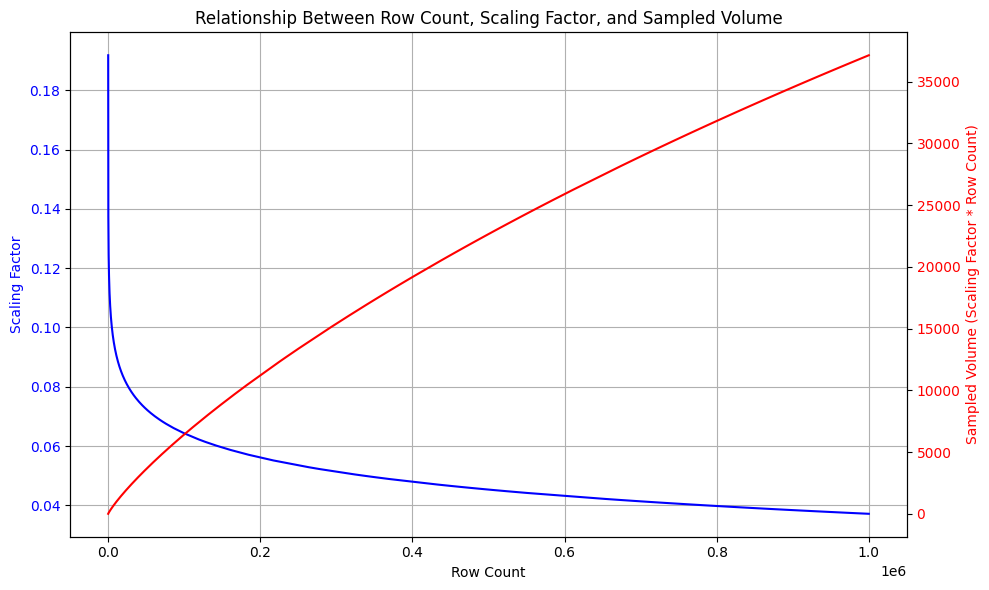

In [ ]:
import matplotlib.pyplot as plt
import math

## Visualization of Scaling Factor and Sampled Volume

# Generate data for the graph
row_counts = range(1, 1000001, 100)  # Row counts from 1 to 10,000,000 in steps of 100
scaling_factors = [compute_scale(x) for x in row_counts]
sampled_volumes = [x * scale for x, scale in zip(row_counts, scaling_factors)]  # Calculate sampled volume

# Plot the graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot scaling factor vs row count
ax1.plot(row_counts, scaling_factors, label="Scaling Factor", color="blue") 
ax1.set_xlabel("Row Count")
ax1.set_ylabel("Scaling Factor", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# Add a second y-axis for sampled volume
ax2 = ax1.twinx()
ax2.plot(row_counts, sampled_volumes, label="Sampled Volume", color="red")
ax2.set_ylabel("Sampled Volume (Scaling Factor * Row Count)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add title and legend
plt.title("Relationship Between Row Count, Scaling Factor, and Sampled Volume")
fig.tight_layout()
plt.show()